# Medida de la dimensión fractal de un depósito de partículas

La estructura de un depósito de partícula depende del mecanismo que atrae a esa partícula hacia la superficie en la que se deposita. Si ese mecanismo deja lugar a la difusión de la partícula, el depósito será muy ramificado; si la fuerza a un movimiento balístico, el depósito será más compacto. Los depósitos más ramificados presentan una estructura fractal, pero según aumenta el número de Peclet (que relaciona los tiempos característicos difusivo y balístico), ese comportamiento fractal se observa en los depósitos sólo hasta un cierto radio.

En este problema se le dan una serie de imágenes obtenidas por simulación de Monte Carlo del crecimiento de un depósito de partículas en 2-D. En la imagen, los píxeles sin partícula depositada tienen el valor 0, los píxeles con partícula depositada (ocupados) tienen el valor 255 y los píxeles donde se podría depositar una partícula (activos) tienen valor 128. En el nombre de cada archivo se indica el valor del número de Peclet de la simulación. El objetivo es que usted calcule, para cada depósito:

- La densidad media del depósito (de los píxeles ocupados). Con los resultados, haga una gráfica de densidad vs. número de Peclet usando la representación más adecuada para ello.

- Una gráfica de "box-counting" para caracterizar el comportamiento fractal. El "box-counting" consiste en recubrir el posible fractal con cajas de un tamaño dado y contar el número de ellas que hacen falta para recubrirlo: representando el número de cajas frente al tamaño de la caja, se obtiene la gráfica de "box-counting". Cuando la imagen es, verdaderamente, la de un fractal de dimensión Df, el resultado es una ley de potencias con exponente igual a -Df (usualmente se emplea una representación log-log, por lo que -Df es la pendiente de una recta). Represente las gráficas de "box-counting" para distintos números de Peclet y estudie su comportamiento.

Nota: una forma rápida de calcular el número de cajas de tamaño L que hacen falta para recubrir un fractal, es rescalando la imagen del fractal en un factor 1/L. El número de píxeles de la nueva imagen que no están vacíos, es el número de cajas de tamaño L necesarias para recubrir el fractal.

## Referencias

[Minkowski–Bouligand dimension](https://en.wikipedia.org/wiki/Minkowski%E2%80%93Bouligand_dimension)

[Box Counting Dimension](https://www.youtube.com/watch?v=f83rCaCkdh4)

[Box counting in numpy](https://francescoturci.net/2016/03/31/box-counting-in-numpy/)

[Box count fractal dimension](https://stackoverflow.com/questions/44793221/python-fractal-box-count-fractal-dimension)

[Fractal Analysis of Time-Series Data Sets: Methods and Challenges](https://www.intechopen.com/books/fractal-analysis/fractal-analysis-of-time-series-data-sets-methods-and-challenges)

In [1]:
from PIL import Image
import numpy as np
import re
import matplotlib.pyplot as plt

# Figures
IMAGES_PATH = "images/"

def extract_peclet(file):
    pe = float(re.match("\S+\=(\S+)\.\S+", file).group(1))
    return pe

def load_image(path):
    imagen = Image.open(path).convert("LA") # LA mode has luminosity (brightness) and alpha
    imagen.load()

    # Replace alpha channel with white color
    im = Image.new("RGB", imagen.size, (255, 255, 255))
    im.paste(imagen, None)
    #img.save("greyscale.png")
    rgb = np.array(im)
    return rgb

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def density(image):
    #pixels=[]
    c = 0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j]>0:
                c += 1
                #pixels.append((i,j))   
    return c / image.size

## Densidad

[0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1000.0, 10.0, 1.0, 2.0, 5.0]
[0.2527427673339844, 0.3294639587402344, 0.43213844299316406, 0.4875297546386719, 0.6233844757080078, 0.7034378051757812, 0.84283447265625, 0.8387012481689453, 0.7540531158447266, 0.8141956329345703, 0.8428878784179688]


/tmp/ipykernel_75/932551564.py:17: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale("log", basex=10)


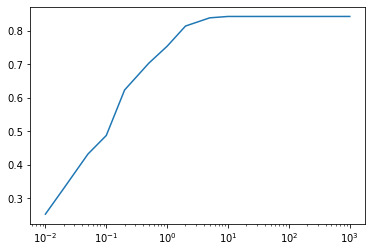

In [2]:
files = !ls images/
peclet = []
den = []

for file in files:
    peclet.append(extract_peclet(file))
    rgb = load_image(IMAGES_PATH + file)
    I = rgb2gray(rgb)
    den.append(density(I))

print(peclet)
print(den)

peclet.sort()
den.sort()

plt.xscale("log", basex=10) 
plt.plot(peclet, den)

## Box Counting

In [3]:
import pylab as pl

# The threshold is used to convert the image to binary. Usually images have 8-bit color depths, which map to 256 values for each pixel. 
# Binary image has only 2 shades - black or white.
# https://gist.github.com/viveksck/1110dfca01e4ec2c608515f0d5a5b1d1
def fractal_dimension(Z, threshold=0.9, label="data"):
    # Only for 2d image
    assert(len(Z.shape) == 2)
    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)
        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])

    # Transform Z into a binary array
    Z = (Z < threshold)
    # Minimal dimension of image
    p = min(Z.shape)
    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))
    # Extract the exponent
    n = int(np.log(n)/np.log(2))
    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)
    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    #fig, ax = pl.subplots()
    
    #ax.plot(np.log(sizes),np.log(counts), "o", mfc="none")
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    #ax.plot(np.log(sizes), np.polyval(coeffs,np.log(sizes)), label=label+" "+str(-coeffs[0]))
    #leg = ax.legend(loc="best")
    return coeffs, sizes, counts

#print("Minkowski–Bouligand dimension (computed): ", fractal_dimension(I, threshold=128))

File:  depo_pe=0.01.tif
Minkowski–Bouligand dimension (computed):  1.7964048733412759 

File:  depo_pe=0.02.tif
Minkowski–Bouligand dimension (computed):  1.8619471698341925 

File:  depo_pe=0.05.tif
Minkowski–Bouligand dimension (computed):  1.9171834628780346 

File:  depo_pe=0.1.tif
Minkowski–Bouligand dimension (computed):  1.93080509300898 

File:  depo_pe=0.2.tif
Minkowski–Bouligand dimension (computed):  1.9710617242103687 

File:  depo_pe=0.5.tif
Minkowski–Bouligand dimension (computed):  1.9741325930098876 

File:  depo_pe=1000.tif
Minkowski–Bouligand dimension (computed):  1.9878011614023368 

File:  depo_pe=10.tif
Minkowski–Bouligand dimension (computed):  1.989024308062554 

File:  depo_pe=1.tif
Minkowski–Bouligand dimension (computed):  1.978080642211204 

File:  depo_pe=2.tif
Minkowski–Bouligand dimension (computed):  1.9877736252213847 

File:  depo_pe=5.tif
Minkowski–Bouligand dimension (computed):  1.99084869483698 



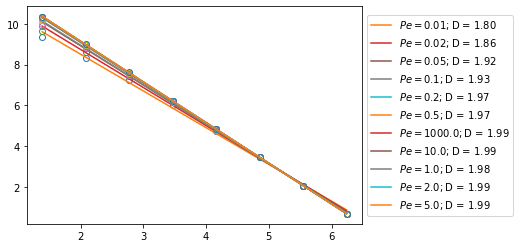

In [4]:
peclet = []

for file in files:
    rgb = load_image(IMAGES_PATH + file)
    I = rgb2gray(rgb)
    peclet.append(extract_peclet(file))
    coeffs, sizes, counts = fractal_dimension(I, threshold=128, label=file)
    print("File: ", file)
    print("Minkowski–Bouligand dimension (computed): ", -coeffs[0], "\n")
    pl.plot(np.log(sizes),np.log(counts), "o", mfc="none")
    pl.plot(np.log(sizes), np.polyval(coeffs,np.log(sizes)), label="$Pe = "+str(peclet[-1])+"; $D = "+"{0:.2f}".format(-coeffs[0]))
    pl.legend(loc="center left", bbox_to_anchor=(1, 0.5), fancybox=True)

In [5]:
def box2(image):
    # finding all the non-zero pixels
    pixels=[]
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j] > 0:
                pixels.append((i,j))

    Lx = image.shape[1]
    Ly = image.shape[0]

    print(Lx, Ly)
    pixels = pl.array(pixels)
    print(pixels.shape)

    # Computing the fractal dimension
    # Considering only scales in a logarithmic list
    scales = np.logspace(0.01, 1, num=10, endpoint=False, base=2)
    Ns = []
    # Looping over several scales
    for scale in scales:
        print ("======= Scale: ", scale)
        # Computing the histogram
        H, edges = np.histogramdd(pixels, bins=(np.arange(0, Lx, scale), np.arange(0, Ly, scale)))
        Ns.append(np.sum(H>0))

    #  Linear fit, polynomial of degree 1
    coeffs = np.polyfit(np.log(scales), np.log(Ns), 1)

    pl.plot(np.log(scales),np.log(Ns), "o", mfc="none")
    pl.plot(np.log(scales), np.polyval(coeffs,np.log(scales)), label=str(-coeffs[0]))
    pl.xlabel("log $\epsilon$")
    pl.ylabel("log N")
    #pl.savefig("sierpinski_dimension.pdf")

    print ("The Hausdorff dimension is", -coeffs[0], "\n") #the fractal dimension is the OPPOSITE of the fitting coefficient
    #np.savetxt("scaling.txt", list(zip(scales,Ns)))

--> file:  depo_pe=0.01.tif 

1024 512
(132510, 2)
======= Scale:  1.0069555500567189
======= Scale:  1.0784804316944516
======= Scale:  1.1550857845535842
======= Scale:  1.2371324786871727
======= Scale:  1.3250070170452075
======= Scale:  1.4191233562003824
======= Scale:  1.5199248564015158
======= Scale:  1.6278863701408692
======= Scale:  1.7435164790741244
======= Scale:  1.8673598898306263
The Hausdorff dimension is 1.6170886810085938 

--> file:  depo_pe=0.02.tif 

1024 512
(172734, 2)
======= Scale:  1.0069555500567189
======= Scale:  1.0784804316944516
======= Scale:  1.1550857845535842
======= Scale:  1.2371324786871727
======= Scale:  1.3250070170452075
======= Scale:  1.4191233562003824
======= Scale:  1.5199248564015158
======= Scale:  1.6278863701408692
======= Scale:  1.7435164790741244
======= Scale:  1.8673598898306263
The Hausdorff dimension is 1.6297974773985824 

--> file:  depo_pe=0.05.tif 

1024 512
(226565, 2)
======= Scale:  1.0069555500567189
======= Scale:  

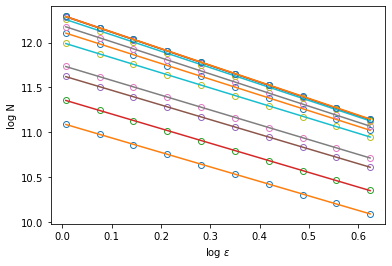

In [6]:
for file in files:
    print("--> file: ", file, "\n")
    peclet.append(extract_peclet(file))
    rgb = load_image(IMAGES_PATH + file)
    I = rgb2gray(rgb)
    box2(I)